# Solving Geoguessr Puzzles with Multimodal Language Models Using RAG

Geoguessr is a popular game where one must guess the location of the presented Google Street View image

![image](https://images.squarespace-cdn.com/content/v1/60f6054f4e76b03092956de8/fbba3851-0172-409c-9eb0-2cbefadce395/Geoguessr+HUD.png)
(Example from https://www.plonkit.net/beginners-guide)

This notebook contains an implementation of RAG for solving these problems with multimodal LLMs, and compares the performance of 3 models: OpenAI's GPT-4o, Google's Gemini-1.5, and Anthropic's Claude 3.5

## Setup for RAG

### Images

The images were downloaded from [https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k?resource=download](https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k?resource=download)

Here is an example:

![image](images/Australia/canvas_1629281323.jpg)

Then, we extract a random image using the function below:

In [1]:
import glob
import pycountry
import random

def get_random_image():
   """Return a dict of path image with its corresponding full country name
   args:
      None
   
   returns:
      dict with fields "country" and "image_path"
   """
   
   paths = glob.glob("./images/*/*.jpg")
   image_path = random.choice(paths)
   # ex. ./images/SLV/img_13.799272601660983,-89.23095180626325.jpg
   substr = image_path[9:]
   country_name = substr[:substr.find('/')]
   
   return {"country": country_name, "image_path": image_path}

### Reference Document

For RAG, we need to retrieve an "expert" document in order to improve the LLM's answer.
The document used is from [https://somerandomstuff1.wordpress.com/2019/02/08/geoguessr-the-top-tips-tricks-and-techniques/](https://somerandomstuff1.wordpress.com/2019/02/08/geoguessr-the-top-tips-tricks-and-techniques/)
It is stored in the file reference.txt

## RAG
The full implementation is stored in rag.py, but an example for OpenAI is shown here

### LLM initialization

In [2]:
import base64
import json
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython.display import Image
from tqdm import tqdm 

load_dotenv() # The API keys are stored in a .env file

True

In [3]:
llm = ChatOpenAI(model="gpt-4o", max_tokens=1024, temperature=0)

### Adding documents into a vector store

In [4]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings) # There are other options for vector stores: https://python.langchain.com/docs/integrations/vectorstores/
document_ids = []

In [5]:
# Load the documents and split it into smaller chunks, 
# since the original document is too large

loader = TextLoader("reference.txt")
reference_doc = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
   chunk_size=1000,  # chunk size (characters)
   chunk_overlap=200,  # chunk overlap (characters)
   add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(reference_doc)
document_ids = vector_store.add_documents(documents=all_splits)

### The RAG Workflow

The RAG logic is as follows:

1. Obtain an initial description of the image

2. Use that description to identify the relevant document chunks that can help with guessing the location

3. Finally, integrate the information to make an improved guess, including the reasoning

In [6]:
# 1. Obtain an initial description of the image
def describe(image_path):
      """An initial LLM description of a given image

      Args:
         image_path (str): path to image

      Returns:
         str: LLM description of image
      """
      with open(image_path, "rb") as image_file:
         image_data = base64.b64encode(image_file.read()).decode('utf-8')
      
      prompt = """
      Describe the image in detail, paying attention to details that can give clues about the location of this image. 
      Here are some example details:
      1. Car license plates
      2. Road marks and signals
      3. Left vs right driving
      4. Language
      5. Vegetation and weather/climate
      6. Geography, Flags
      7. House shape/materials
      ... and any other noteworthy details, no matter how small they are
      
      Finally, take a guess as to which country of the photo
      """

      msg = llm.invoke(
         [
               HumanMessage(
                  content=[
                     {"type": "text", "text": prompt},
                     {
                           "type": "image_url",
                           "image_url": {"url": f"data:image/png;base64,{image_data}"},
                     },
                  ]
               )
         ]
      )
      description = msg.content
      return description

In [7]:
# 2. Use that description to identify the relevant document chunks 
# that can help with guessing the location
def retrieve(location_clues):
   """Given a description of the location, find sections of the reference document
   that can help make a better guess

   Args:
      location_clues (str): Initial LLM description of picture

   Returns:
      str: Contents of relevent document chunks
   """
   retrieved_docs = vector_store.similarity_search(location_clues, k=3) # find relevant docs to the query
   docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
   return docs_content

In [8]:
# 3. Finally, integrate the information to make an improved guess, 
# including the reasoning
def generate(context, image_path):
   """Make an educated guess after consulting reference with RAG

   Args:
      context (str): Relevent document materials from vector store
      image_path (str): Path to image

   Returns:
      str: Output of the LLM
   """
   with open(image_path, "rb") as image_file:
      image_data = base64.b64encode(image_file.read()).decode('utf-8')
      
   prompt = f"""
      Carefully analyze the photo, in order to correctly guess the location of the photo.
      Give an elaborate reasoning as to why you chose the country. 
      You may include relevant details such as (don't include them if they are not relevant): 
      1. Car license plates
      2. Road marks and signals
      3. Left vs right driving
      4. Language
      5. Vegetation and weather
      6. Geography, Flags
      7. House shape/materials
      ... and any other noteworthy details, and corroborate with the following reference material,
      
      Some relevant materials: {context}
      
      Return your answer strictly in the following JSON format:
      {{
         "country" : "[country]",
         "reason" : "[reason]"
         
      }}
   """
   
   msg = llm.invoke(
      [
         HumanMessage(
            content=[
               {"type": "text", "text": prompt},
               {
                     "type": "image_url",
                     "image_url": {"url": f"data:image/png;base64,{image_data}"},
               },
            ]
         )
      ]
   )
   
   return msg.content

In [9]:
# Putting it all together:
def guess_location(image_path):
   """Use RAG to guess location of a Google Street View image

   Args:
      image_path (str): Path to image

   Returns:
      dict: dict containing the initial discription, the relevant docs, and the final response
   """

   initial_description = describe(image_path)
   reference = retrieve(initial_description)
   result = generate(reference, image_path)
   
   # extract guess from returned string, which should be in json form
   response = result.replace("`","")
   response = response.replace("json","")
   response = json.loads(response)

   
   return {"initial_description": initial_description, "reference": reference, "country": response["country"], "reason": response["reason"]}

Image from: Brazil


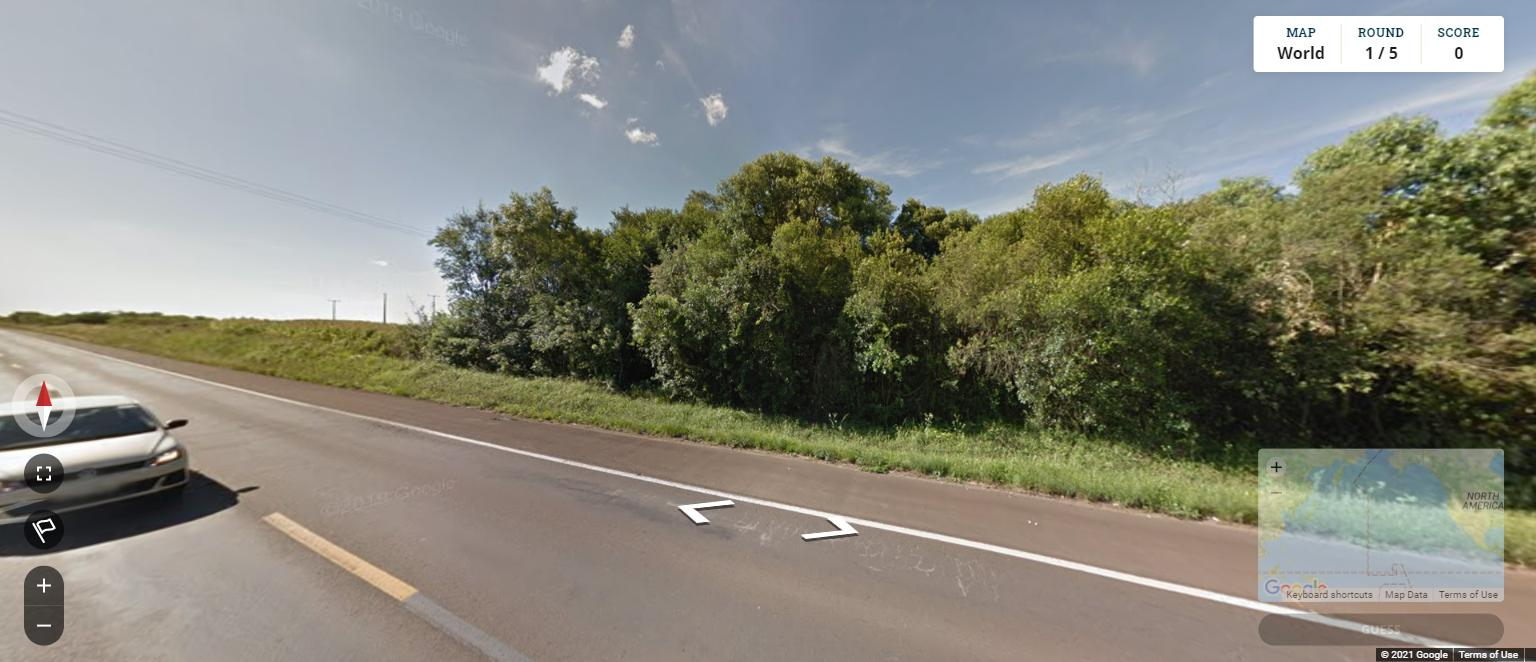

In [10]:
# An example run:
random_image = get_random_image()
print("Image from:", random_image["country"])
Image(filename=random_image["image_path"]) 

In [11]:
guess = guess_location(random_image["image_path"])

In [12]:
print("Initial Description:\n", guess["initial_description"])

Initial Description:
 The image shows a rural road with a car driving on the right side, indicating a right-hand traffic system. The road has a solid white line on the right edge and a dashed yellow line in the center, which is typical in many countries for dividing lanes of traffic moving in opposite directions.

The vegetation is lush and green, suggesting a temperate or subtropical climate. The sky is clear with a few clouds, indicating fair weather.

There are no visible signs, language, or license plates that can provide additional clues about the location. The landscape is relatively flat with some gentle slopes, and there are no distinctive geographical features or flags visible.

Based on the road markings and vegetation, this scene could be in a country like Brazil or Argentina, where right-hand driving is the norm and the climate can support such vegetation. My guess would be Brazil.


In [13]:
print("Retrieved Documents:\n", guess["reference"])

Retrieved Documents:
 Brazil has a few unique features including its signs. The back of Brazilian signs are coloured black. Brazilian utility poles most commonly have large indents, are narrower near the top and contain a number of vertically aligned small, drilled holes. The Street View car in Brazil should either be blue or white. This white car may have a stubby aerial or no aerial at all.
One of the easiest ways to identify Brazil is via language. From the GeoGuessr relevant countries, Brazil is the only place other than Portugal and Macau where Portuguese is spoken. This can make identifying Brazil from the rest of South America easy as Spanish is spoken across the rest of the GeoGuessr relevant South America. The Brazilian highway numbering system is explained in detail in the ‘highway numbering systems’ section of this article.

Large concrete, rectangular blocks that make up the road comprise the majority of the roads in the Philippines. This feature can also be seen in Thailan

In [14]:
print("Final Output:\n", guess["country"]+"\n", guess["reason"])

Final Output:
 Brazil
 The road has a yellow center line and white side lines, which are common in Brazil. The vegetation is lush and tropical, consistent with Brazil's climate. The car is driving on the right, which matches Brazil's driving rules. The overall road condition and the presence of dense greenery suggest a location in South America, and the specific road markings and vegetation are indicative of Brazil.


## Comparison
Here is a comparison of all of the models:

In [15]:
from rag import LLM_Guesser
from utils import get_random_image
num_trials = 20

In [16]:
locations = []
image_paths = []
for _ in range(num_trials):
   image = get_random_image()
   locations.append(image["country"])
   image_paths.append(image["image_path"])

print("Locations:", locations)

Locations: ['South Africa', 'Germany', 'Japan', 'Argentina', 'United Kingdom', 'United States', 'Ukraine', 'Russia', 'United States', 'United States', 'United States', 'Brazil', 'United States', 'North Macedonia', 'Mexico', 'United States', 'Japan', 'Israel', 'Italy', 'Mongolia']


In [ ]:
openai_score = 0
for i in tqdm(range(num_trials)):
   llm = LLM_Guesser("GPT")
   guess = llm.guess_location(image_paths[i])["country"]
   if guess.upper() == locations[i].upper(): openai_score += 1
openai_score /= num_trials
print("Score for GPT-4o:", openai_score)

  5%|▌         | 1/20 [00:15<04:48, 15.18s/it]

In [ ]:
anthropic_score = 0
for i in tqdm(range(num_trials)):
   llm = LLM_Guesser("Claude")
   guess = llm.guess_location(image_paths[i])["country"]
   if guess.upper() == locations[i].upper(): anthropic_score += 1
anthropic_score /= num_trials
print("claude-3-5-sonnet:", anthropic_score)

  0%|          | 0/20 [00:04<?, ?it/s]


NameError: name 'image_paths' is not defined

In [ ]:
google_score = 0
for i in tqdm(range(num_trials)):
   llm = LLM_Guesser("Gemini")
   guess = llm.guess_location(image_paths[i])["country"]
   if guess.upper() == locations[i].upper(): google_score += 1
google_score /= num_trials
print("gemini-1.5:", google_score)

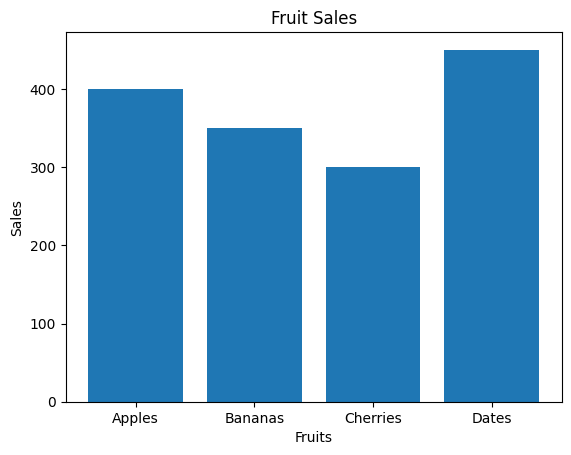

In [ ]:
import matplotlib.pyplot as plt

models = ['GPT', 'Claude', 'Gemini']
scores = [openai_score*100, anthropic_score*100, google_score*100]

plt.bar(models, scores)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

It appears that [] has performed the best